# Compare Countries — Benin, Sierra Leone, Togo
Branch: compare-countries
Notebook: compare_countries.ipynb

Objective: Synthesize cleaned datasets to compare GHI, DNI, DHI across countries.

In [2]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 906.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 KB 1.7 MB/s eta 0:00:00a 0:00:01


In [13]:
# Cell 1 — Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

# Output folder
OUT_DIR = 'outputs'
os.makedirs(OUT_DIR, exist_ok=True)



In [20]:
# Cell 2 — Paths & load data
# Update these paths if your CSV filenames differ
paths = {
    'Benin': '../data/benin_clean.csv',
    'Sierra Leone': '../data/serraleone_clean.csv',
    'Togo': '../data/togo_clean.csv'
}

# Load CSVs with basic checks
dfs = {}
for country, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Expected file for {country} not found at: {p}")
    df = pd.read_csv(p)
    # Make columns consistent (strip whitespace, uppercase)
    df.columns = [c.strip() for c in df.columns]
    dfs[country] = df
    print(f"Loaded {country}: {df.shape[0]} rows, columns: {df.shape[:1]}")


Loaded Benin: 525600 rows, columns: (525600,)
Loaded Sierra Leone: 525600 rows, columns: (525600,)
Loaded Togo: 525600 rows, columns: (525600,)


In [21]:
# Cell 3 — Sanity check for required metrics and combine
metrics = ['GHI', 'DNI', 'DHI']

# Ensure the required columns exist; try case-insensitive match
def ensure_cols(df, metrics):
    col_map = {}
    lower_cols = {c.lower(): c for c in df.columns}
    for m in metrics:
        if m in df.columns:
            col_map[m] = m
        elif m.lower() in lower_cols:
            col_map[m] = lower_cols[m.lower()]
        else:
            raise KeyError(f"Metric '{m}' not found in dataframe columns: {list(df.columns)}")
    return col_map

# Standardize metric columns and add country column
for country, df in dfs.items():
    col_map = ensure_cols(df, metrics)
    # Create standardized columns
    for m in metrics:
        dfs[country][m] = pd.to_numeric(df[col_map[m]], errors='coerce')
    dfs[country]['country'] = country

# Combine
combined = pd.concat(dfs.values(), ignore_index=True)
print("Combined shape:", combined.shape)
combined[metrics + ['country']].head()


Combined shape: (1576800, 21)


,GHI,DNI,DHI,country
0,-1.200,-0.200,-1.100,Benin
1,-1.100,-0.200,-1.100,Benin
2,-1.100,-0.200,-1.100,Benin
3,-1.100,-0.100,-1.000,Benin
4,-1.000,-0.100,-1.000,Benin


In [22]:
# Cell 4 — Summary table (mean, median, std) by country
agg = combined.groupby('country')[metrics].agg(['mean', 'median', 'std']).round(3)
# flatten multiindex
agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
agg = agg.reset_index()
agg


,country,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
0,Benin,240.213,1.800,330.722,143.018,-0.100,236.124,105.549,1.600,146.640
1,Sierra Leone,171.585,0.300,263.830,13.681,-0.100,45.429,108.544,-0.100,152.331
2,Togo,227.032,2.100,318.663,2.330,0.000,10.017,103.104,2.500,140.807


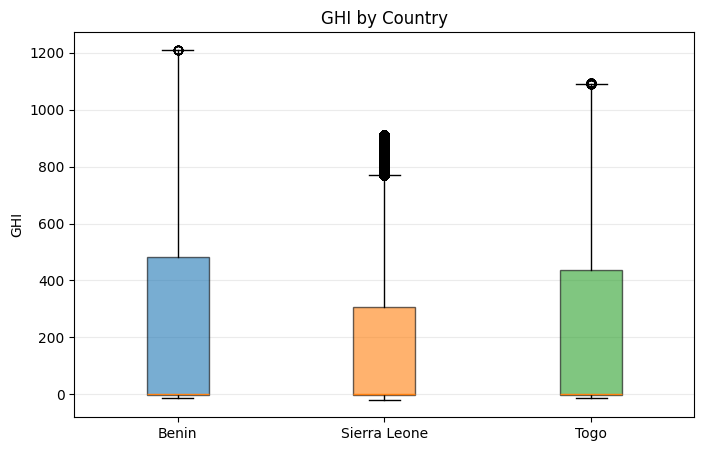

Saved: outputs/boxplot_ghi.png


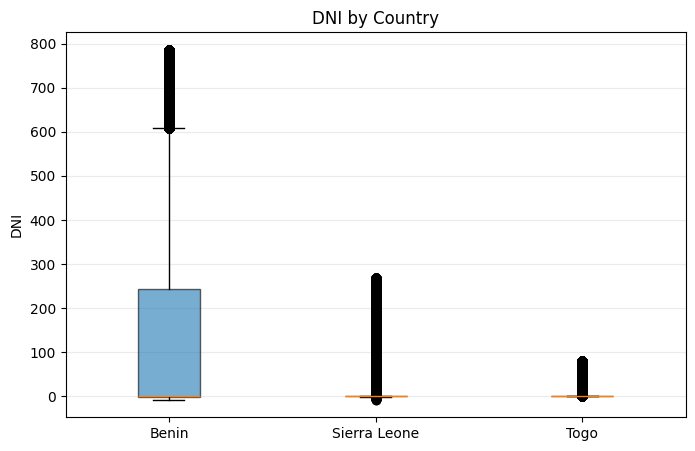

Saved: outputs/boxplot_dni.png


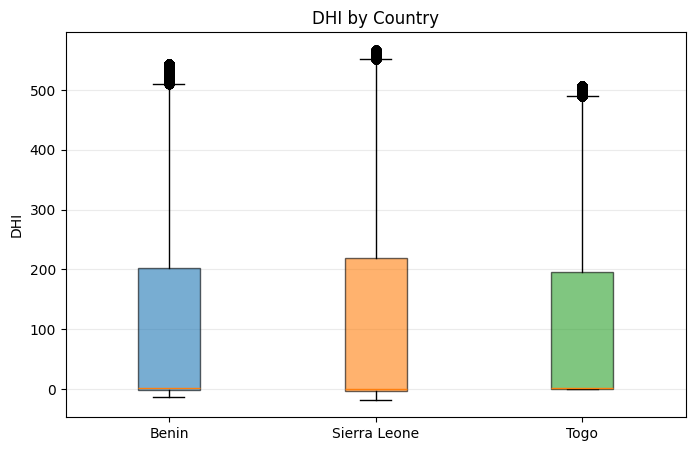

Saved: outputs/boxplot_dhi.png


In [23]:
# Cell 5 — Boxplots side-by-side (one plot per metric), colored by country
# Colors (choose distinct colors)
country_order = list(dfs.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(country_order)]

for metric in metrics:
    plt.figure(figsize=(8,5))
    # Create a list of arrays in country order
    data = [combined.loc[combined['country']==c, metric].dropna() for c in country_order]
    b = plt.boxplot(data, labels=country_order, patch_artist=True, showfliers=True)
    # Color boxes
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    plt.title(f'{metric} by Country')
    plt.ylabel(metric)
    plt.grid(axis='y', alpha=0.25)
    outp = os.path.join(OUT_DIR, f'boxplot_{metric.lower()}.png')
    plt.savefig(outp, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", outp)


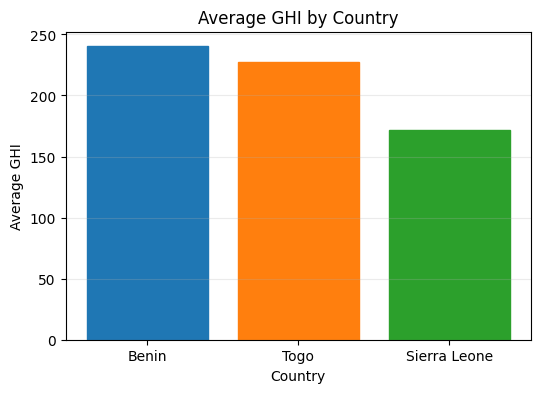

Saved: outputs/avg_ghi_by_country.png


In [24]:
# Cell 6 — Bar chart: ranking by average GHI
avg_ghi = combined.groupby('country')['GHI'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
bars = plt.bar(avg_ghi.index, avg_ghi.values)
# color bars to match order
for bar, color in zip(bars, colors):
    bar.set_color(color)
plt.title('Average GHI by Country')
plt.ylabel('Average GHI')
plt.xlabel('Country')
plt.grid(axis='y', alpha=0.25)
outp = os.path.join(OUT_DIR, 'avg_ghi_by_country.png')
plt.savefig(outp, bbox_inches='tight', dpi=150)
plt.show()
print("Saved:", outp)


In [25]:
# Cell 7 — Statistical testing on GHI
# Extract GHI samples per country
samples = [combined.loc[combined['country']==c, 'GHI'].dropna() for c in country_order]
for c, s in zip(country_order, samples):
    print(f"{c}: n={len(s)}, mean={s.mean():.3f}, median={s.median():.3f}, std={s.std():.3f}")

# Normality check (Shapiro) -- careful: very large samples make Shapiro sensitive
print("\nShapiro normality test (if n between 3 and 5000):")
for c, s in zip(country_order, samples):
    if 3 <= len(s) <= 5000:
        stat, p = stats.shapiro(s)
        print(f"  {c}: W={stat:.4f}, p={p:.4g}")
    else:
        print(f"  {c}: Skipping Shapiro (n={len(s)})")

# Levene test for equal variances
try:
    lev_stat, lev_p = stats.levene(*samples, center='median')
    print(f"\nLevene test: stat={lev_stat:.4f}, p={lev_p:.4g}")
except Exception as e:
    print("Levene test failed:", e)

# Decide which test to use:
# - If normality & homogeneity acceptable -> one-way ANOVA
# - Otherwise -> Kruskal-Wallis
use_anova = True
# Basic heuristic: if any Shapiro p < 0.05, don't use ANOVA
for c, s in zip(country_order, samples):
    if 3 <= len(s) <= 5000:
        stat, p = stats.shapiro(s)
        if p < 0.05:
            use_anova = False
            break

if use_anova:
    try:
        fstat, p_anova = stats.f_oneway(*samples)
        print(f"\nOne-way ANOVA: F={fstat:.4f}, p={p_anova:.4g}")
    except Exception as e:
        print("ANOVA failed:", e)
        use_anova = False

if not use_anova:
    try:
        hstat, p_kw = stats.kruskal(*samples)
        print(f"\nKruskal-Wallis: H={hstat:.4f}, p={p_kw:.4g}")
    except Exception as e:
        print("Kruskal-Wallis failed:", e)


Benin: n=525600, mean=240.213, median=1.800, std=330.722
Sierra Leone: n=525600, mean=171.585, median=0.300, std=263.830
Togo: n=525600, mean=227.032, median=2.100, std=318.663

Shapiro normality test (if n between 3 and 5000):
  Benin: Skipping Shapiro (n=525600)
  Sierra Leone: Skipping Shapiro (n=525600)
  Togo: Skipping Shapiro (n=525600)

Levene test: stat=7089.5096, p=0

One-way ANOVA: F=7454.9749, p=0


In [26]:
# Cell 8 — Post-hoc pairwise comparisons (Tukey HSD) if ANOVA is significant
# We'll run Tukey HSD on the combined GHI column
combined_ghi = combined[['GHI', 'country']].dropna()
if combined_ghi['country'].nunique() < 2:
    print("Not enough country groups for pairwise tests.")
else:
    # Tukey HSD requires statsmodels; pairwise_tukeyhsd is imported above
    try:
        tukey = pairwise_tukeyhsd(endog=combined_ghi['GHI'], groups=combined_ghi['country'], alpha=0.05)
        print(tukey.summary())
        # Save a pandas table of results
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukey_df.to_csv(os.path.join(OUT_DIR, 'tukey_hsd_ghi.csv'), index=False)
        print("Saved Tukey HSD results to:", os.path.join(OUT_DIR, 'tukey_hsd_ghi.csv'))
    except Exception as e:
        print("Tukey HSD failed (maybe non-equal group sizes or other issue):", e)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
       Benin Sierra Leone -68.6279  -0.0 -70.0259 -67.2298   True
       Benin         Togo -13.1806  -0.0 -14.5787 -11.7826   True
Sierra Leone         Togo  55.4472  -0.0  54.0492  56.8452   True
-----------------------------------------------------------------
Saved Tukey HSD results to: outputs/tukey_hsd_ghi.csv


In [28]:
pip install tabulate


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
